In [1]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

In [2]:
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://www.healthypawspetinsurance.com/Images/V3/DogAndPuppyInsurance/Dog_CTA_Desktop_HeroImage.jpg'

In [3]:
model_id = 2
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

In [4]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [6]:
params = list(net.parameters())

In [7]:
weight_softmax = np.squeeze(params[-2].data.numpy())

In [8]:
weight_softmax.shape

(1000, 512)

In [9]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [10]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

In [11]:
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [12]:
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
#img_pil = Image.open('xxxx.jpg')
img_pil.save('test.jpg')

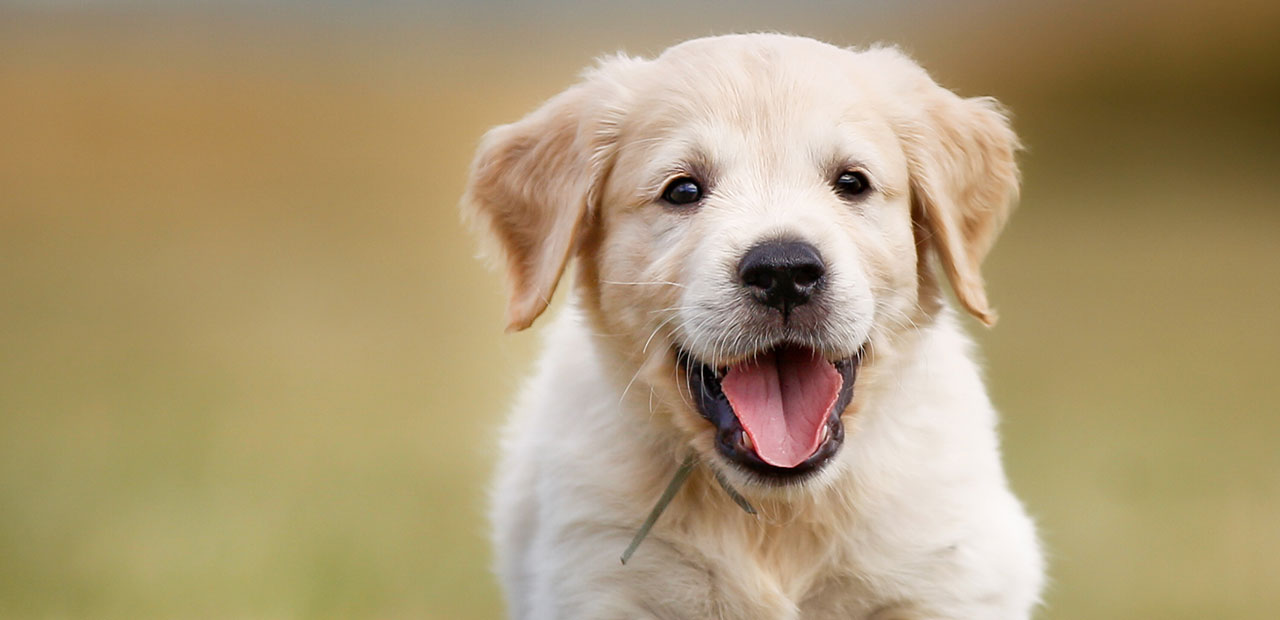

In [13]:
img_pil

In [14]:
img_tensor = preprocess(img_pil)

In [15]:
img_variable = Variable(img_tensor.unsqueeze(0))

In [16]:
img_tensor.shape

torch.Size([3, 224, 224])

In [17]:
logit = net(img_variable)

In [18]:
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

In [19]:
h_x = F.softmax(logit, dim=1).data.squeeze()

In [20]:
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [21]:
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

In [22]:
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape

output CAM.jpg for the top1 prediction: golden retriever


In [23]:
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)

In [24]:
result = heatmap * 0.3 + img * 0.5

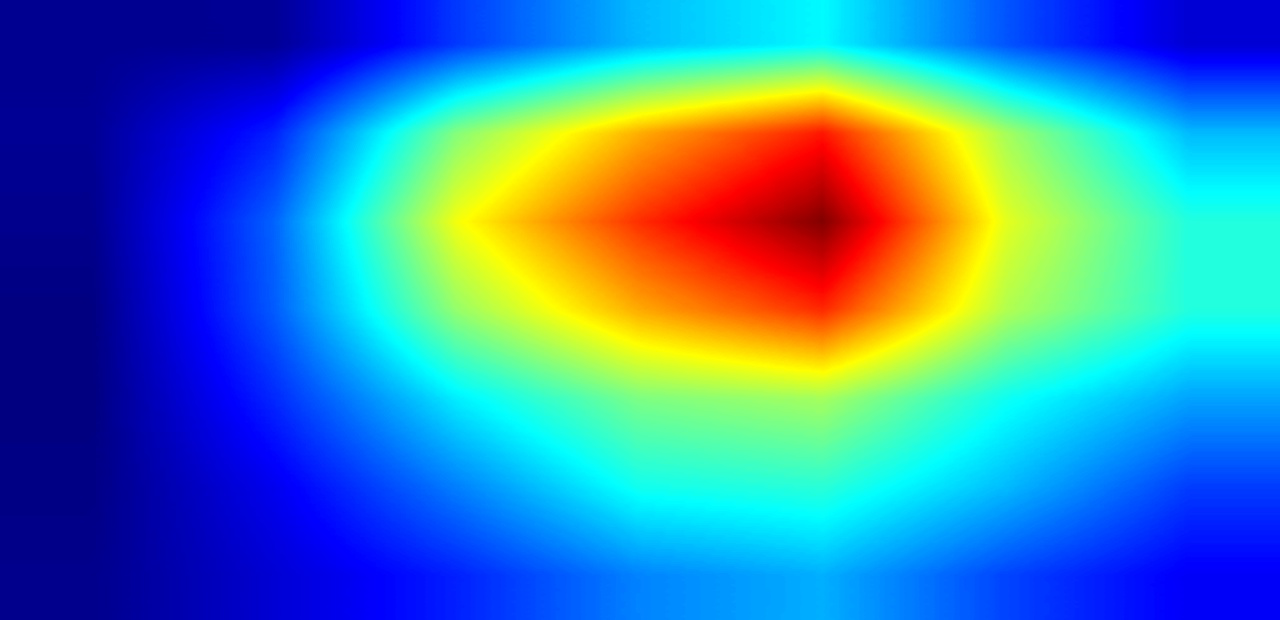

In [25]:
cv2.imwrite('heatmap.jpg', heatmap)
heat = Image.open('heatmap.jpg')
heat

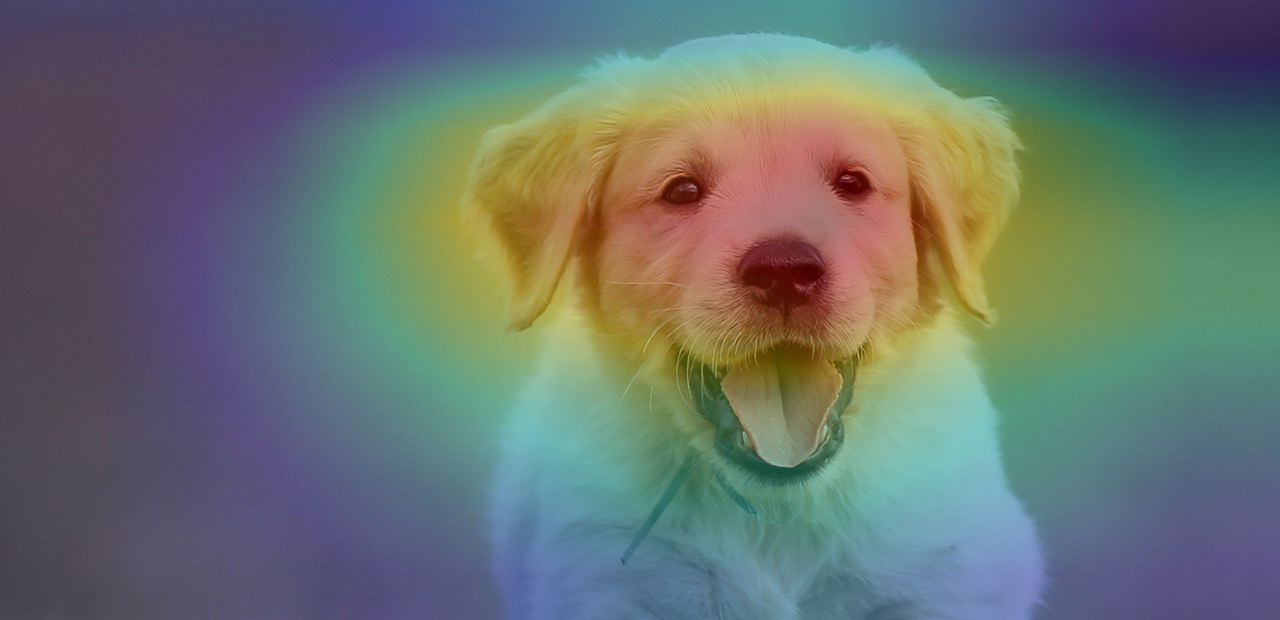

In [26]:
cv2.imwrite('result.jpg', result)
result_pic = Image.open('result.jpg')
result_pic

In [27]:
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.730 -> golden retriever
0.111 -> clumber, clumber spaniel
0.083 -> Labrador retriever
0.038 -> Great Pyrenees
0.026 -> kuvasz
